# Mustererkennung/Machine Learning - Assignment 9

### Load the spam dataset:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import random
from tqdm import tqdm

In [2]:
path_to_train = 'zip.train'
path_to_test = 'zip.test'
training_data = np.array(pd.read_csv(path_to_train, sep=' ', header=None))
test_data = np.array(pd.read_csv(path_to_test, sep =' ',header=None))

X_train, y_train = training_data[:,1:-1], training_data[:,0]
X_test, y_test = test_data[:,1:], test_data[:,0]

In [3]:
def standardize(x):
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

def to_one_hot(y, num_classes):
    return np.eye(num_classes)[y.astype(np.uint)]

def softmax(x):
    exp = np.exp(x)
    summed = np.sum(exp, axis=1, keepdims=True)
    return exp / summed

def accuracy(y_true, y_pred):
    """
    y_true should be a one hot encoded vector.
    """
    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    return np.mean(y_true == y_pred)

class Sigmoid():
    def forward(self, x):
        z = 1 / (1 + np.exp(-x)) 
        self.z = z
        return z
    
    def backward(self, right_dev):
        return self.z * (1.0 - self.z) * right_dev.T
    
class CategoricalCrossEntropy():
    """
    Softmax + CategoricalCrossentropy
    """
    def forward(self, x, y):
        y_pred = softmax(x)
        loss = (1.0 / x.shape[0]) * -np.sum(np.log(np.max(y_pred * y, axis=1)))
        self.y_pred = y_pred
        self.y_true = y
        return loss
        
    def backward(self, right_dev):
        return (self.y_pred - self.y_true) * right_dev
    
class DenseLayer():
    def __init__(self, input_dims, output_dims, activation=None):
        self.w = np.random.normal(size=(input_dims, output_dims))
        self.b = np.ones((1, output_dims))
        self.activation = activation
        
    def forward(self, x):
        self.x = x
        x = x @ self.w + self.b
        if self.activation:
            x = self.activation.forward(x)
        return x
    
    def backward(self, right_dev):
        if self.activation:
            act_grad = self.activation.backward(right_dev)
        else:
            act_grad = right_dev
        self.grad_w = self.x.T @ act_grad
        self.grad_b = np.sum(act_grad, axis=0, keepdims=True)
        return self.w @ act_grad.T
    
    def apply_gradients(self, lr):
        self.w = self.w - lr * self.grad_w
        self.b = self.b - lr * self.grad_b
    
class NeuralNetwork():
    def __init__(self, layers, loss):
        self.layers = layers
        self.loss = loss
        
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def predict(self, x):
        return softmax(self.forward(x))
    
    def fit(self, x, y, epochs, lr, x_val = None, y_val = None):
        losses = []
        train_accs = []
        val_accs = []
        
        for epoch in tqdm(range(1, epochs + 1)):
            y_pred = self.forward(x)
            loss = self.loss.forward(y_pred, y)
            right_dev = 1.0
            right_dev = self.loss.backward(right_dev)
            for layer in self.layers[::-1]:
                right_dev = layer.backward(right_dev)
            for layer in self.layers:
                layer.apply_gradients(lr)
            
            if isinstance(x_val, np.ndarray) and isinstance(y_val, np.ndarray):
                y_pred_val = self.predict(x_val)
                val_accs.append(accuracy(y_val, y_pred_val))
            
            train_accs.append(accuracy(y, softmax(y_pred)))
            losses.append(loss)
                   
        return losses, train_accs, val_accs

In [4]:
num_classes = len(np.unique(y_train))
y_train, y_test = to_one_hot(y_train, num_classes), to_one_hot(y_test, num_classes)
X_train, X_test = standardize(X_train), standardize(X_test) 

In [5]:
layers = [
    DenseLayer(X_train.shape[1], 30, activation=Sigmoid()),
    DenseLayer(30, 30, activation=Sigmoid()),
    DenseLayer(30, 30, activation=Sigmoid()),
    DenseLayer(30, num_classes)
]

clf = NeuralNetwork(layers, CategoricalCrossEntropy())

y_pred = clf.predict(X_test)
print(np.argmax(y_pred, axis=1))

losses, train_accs, val_accs = clf.fit(X_train, y_train, epochs=1000, lr=0.00005, x_val=X_test, y_val=y_test)

y_pred = clf.predict(X_test)
print(np.argmax(y_pred, axis=1))

  0%|          | 3/1000 [00:00<00:45, 22.15it/s]

[0 0 0 ... 0 0 0]


100%|██████████| 1000/1000 [00:39<00:00, 25.51it/s]

[9 6 3 ... 4 0 1]


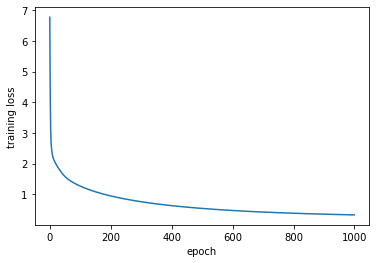

In [10]:
plt.plot(list(range(len(losses))), losses)
plt.xlabel("epoch")
plt.ylabel("training loss")
plt.show()

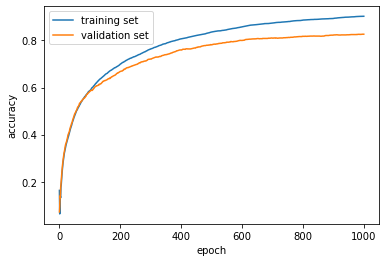

In [11]:
plt.plot(list(range(len(train_accs))), train_accs, label="training set")
plt.plot(list(range(len(val_accs))), val_accs, label="validation set")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()